# Análisis Climático — Pereira, Risaralda
**Mini Proyecto 1 — Física del Clima y Cambio Climático**

Fuentes: IDEAM (promedio de estaciones) y NASA POWER (datos grillados)  
Período: 2015–2025 | Variables: Temperatura, Precipitación, Humedad relativa

In [1]:
# ============================================================
# 0. IMPORTS Y CONFIGURACIÓN
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from scipy import fft
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'figure.dpi': 120,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 10,
})

# Colores consistentes por fuente
C_IDEAM = '#1f77b4'   # azul
C_NASA  = '#d62728'   # rojo

# Límite del eje temporal — evita que matplotlib extienda el eje a 2026
FECHA_INI = pd.Timestamp('2015-01-01')
FECHA_FIN = pd.Timestamp('2025-12-31')

# Estaciones bimodales Eje Cafetero
ESTACIONES = {
    'Seco 1 (Dic–Feb)':     [12, 1, 2],
    'Lluvioso 1 (Mar–May)': [3, 4, 5],
    'Seco 2 (Jun–Ago)':     [6, 7, 8],
    'Lluvioso 2 (Sep–Nov)': [9, 10, 11],
}
ESTACION_COLORS = {
    'Seco 1 (Dic–Feb)':     '#f4a460',
    'Lluvioso 1 (Mar–May)': '#4682b4',
    'Seco 2 (Jun–Ago)':     '#daa520',
    'Lluvioso 2 (Sep–Nov)': '#2e8b57',
}

print('Librerías cargadas correctamente.')

Librerías cargadas correctamente.


In [2]:
# ============================================================
# 1. CARGA DE DATOS
# ============================================================
ideam = pd.read_csv('../data/processed/ideam_daily.csv', parse_dates=['fecha'])
nasa  = pd.read_csv('../data/processed/nasa_daily.csv',  parse_dates=['fecha'])

ideam = ideam.set_index('fecha').sort_index()
nasa  = nasa.set_index('fecha').sort_index()

# Columnas de trabajo
VARS = {
    'temperatura_c':    ('Temperatura',      '°C'),
    'precipitacion_mm': ('Precipitación',    'mm/día'),
    'humedad_pct':      ('Humedad relativa', '%'),
}

print('IDEAM:', ideam.shape, '| Nulls:')
print(ideam.isnull().sum())
print()
print('NASA:', nasa.shape, '| Nulls:')
print(nasa.isnull().sum())
print()
print('Estadísticas IDEAM:')
print(ideam.describe().round(2))
print()
print('Estadísticas NASA:')
print(nasa.describe().round(2))

IDEAM: (4018, 3) | Nulls:
temperatura_c       0
precipitacion_mm    0
humedad_pct         0
dtype: int64

NASA: (4018, 3) | Nulls:
temperatura_c       0
precipitacion_mm    0
humedad_pct         0
dtype: int64

Estadísticas IDEAM:
       temperatura_c  precipitacion_mm  humedad_pct
count        4018.00           4018.00      4018.00
mean           22.33              5.74        77.95
std             1.39              9.44         7.69
min            17.33              0.00        40.32
25%            21.47              0.14        74.08
50%            22.25              2.71        77.95
75%            23.11              7.16        81.84
max            28.53            111.40       100.00

Estadísticas NASA:
       temperatura_c  precipitacion_mm  humedad_pct
count        4018.00           4018.00      4018.00
mean           16.37              5.15        86.62
std             0.75              6.16         4.08
min            13.46              0.00        67.47
25%            15.87 

---
## Punto 5 — Series de tiempo y anomalías

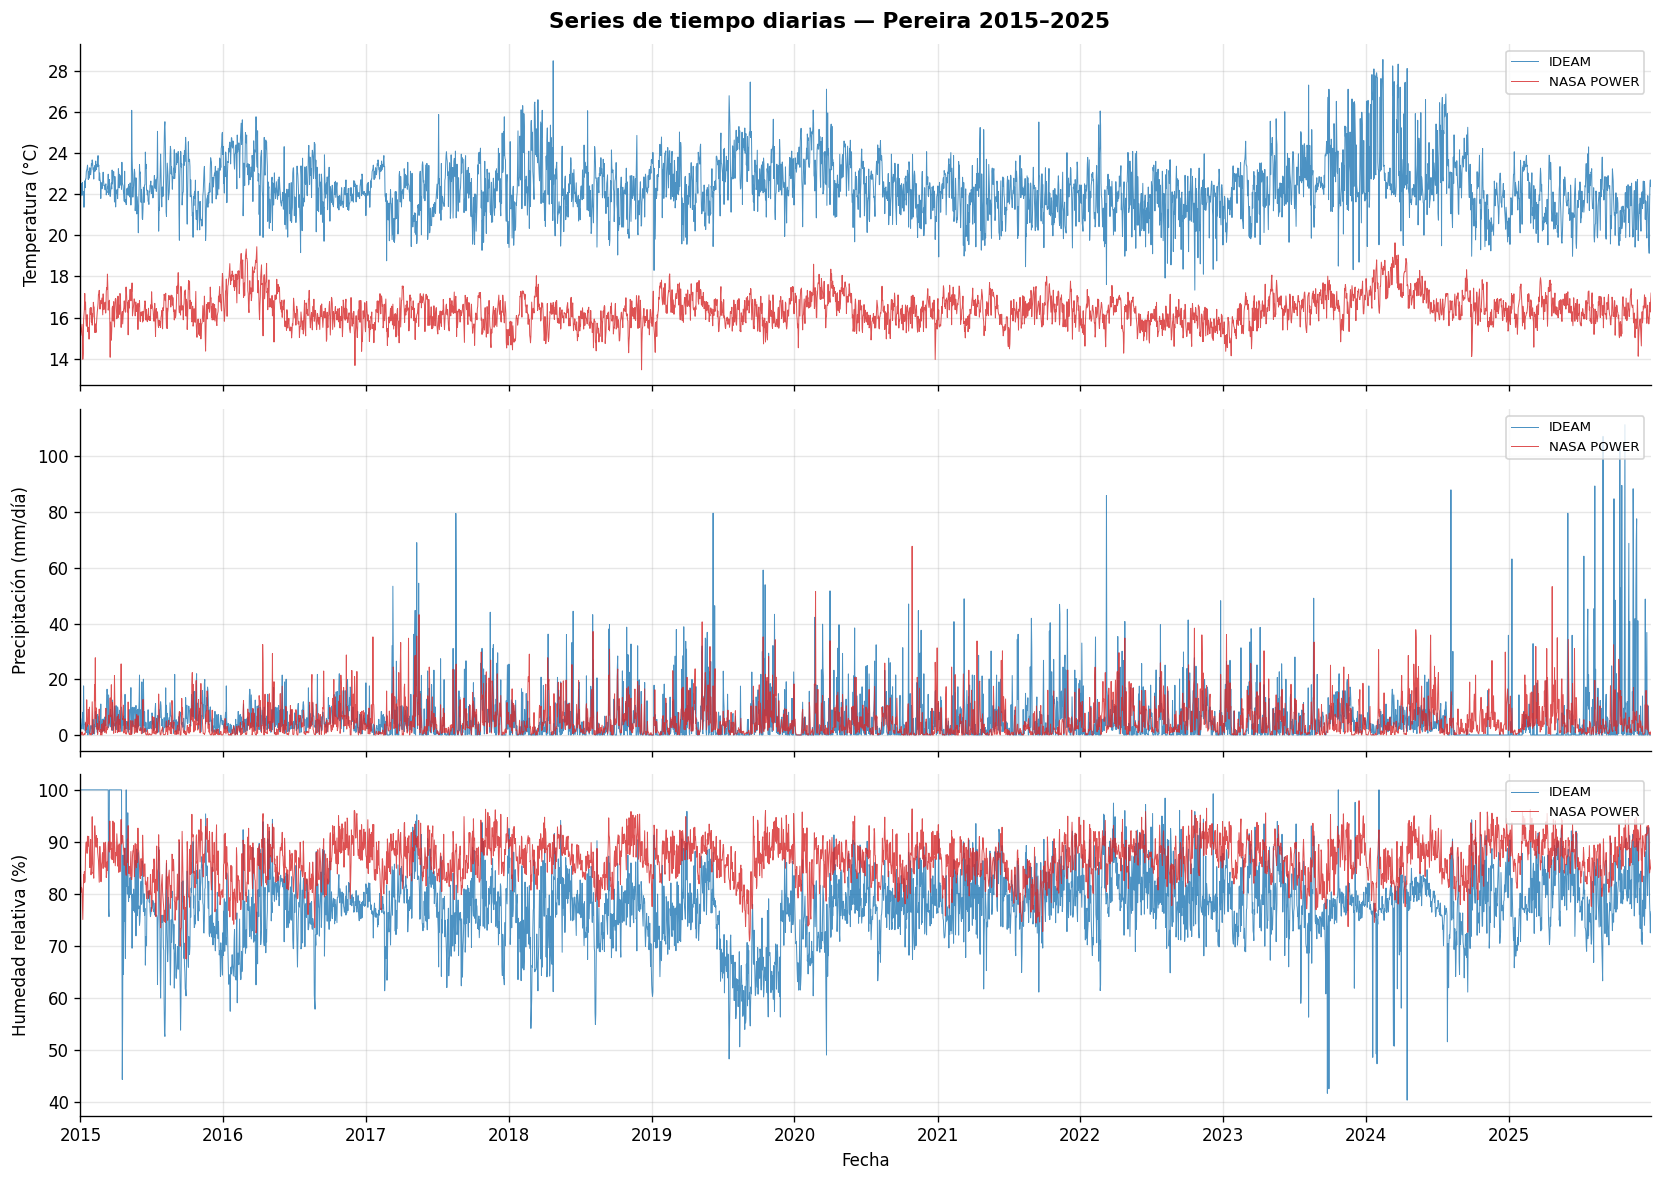

In [3]:
# ============================================================
# 5A. SERIES DIARIAS
# ============================================================
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle('Series de tiempo diarias — Pereira 2015–2025', fontsize=13, fontweight='bold')

for ax, (col, (nombre, unidad)) in zip(axes, VARS.items()):
    ax.plot(ideam.index, ideam[col], color=C_IDEAM, lw=0.6, alpha=0.8, label='IDEAM')
    ax.plot(nasa.index,  nasa[col],  color=C_NASA,  lw=0.6, alpha=0.8, label='NASA POWER')
    ax.set_ylabel(f'{nombre} ({unidad})')
    ax.legend(loc='upper right', fontsize=8)

axes[-1].set_xlim(FECHA_INI, FECHA_FIN)
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.savefig('../results/plots/01_series_diarias.png', bbox_inches='tight')
plt.show()

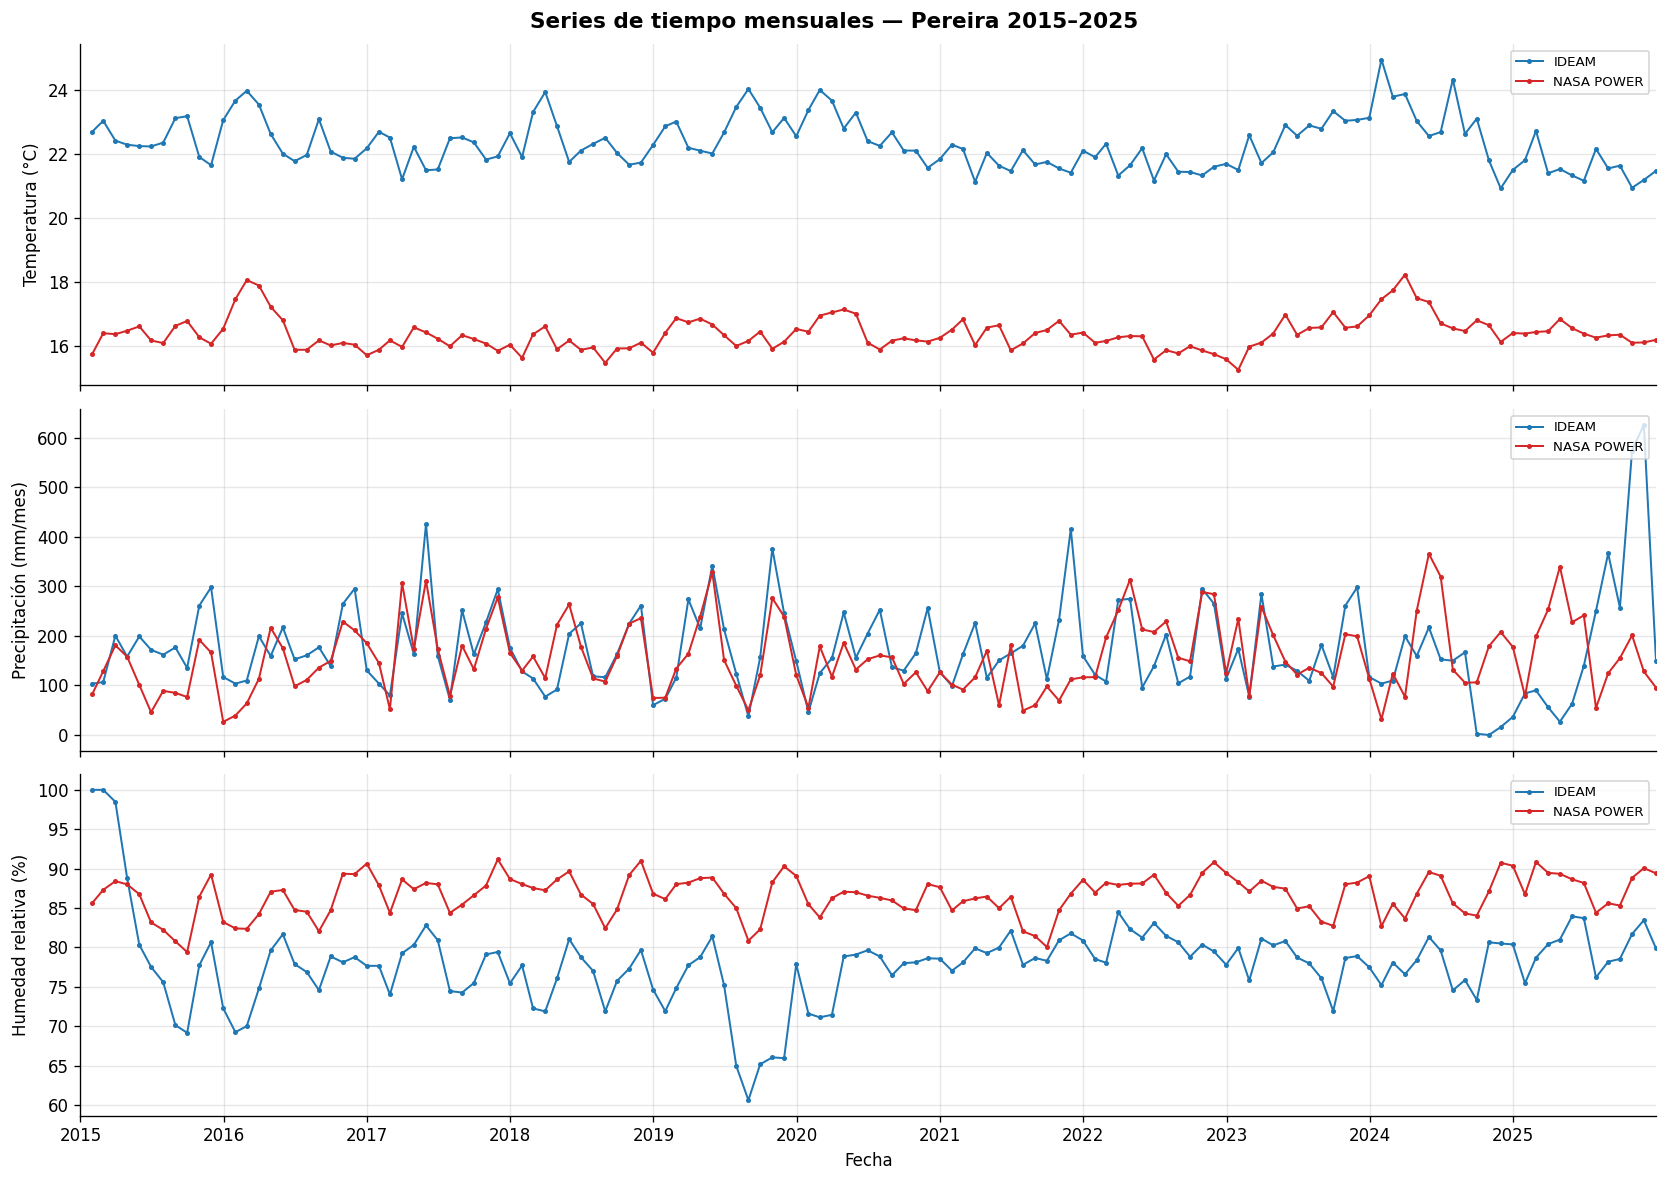

In [4]:
# ============================================================
# 5B. SERIES MENSUALES
# ============================================================
ideam_m = ideam.resample('ME').mean(numeric_only=True)
nasa_m  = nasa.resample('ME').mean(numeric_only=True)

# Precipitación mensual = suma, no promedio
ideam_m['precipitacion_mm'] = ideam.resample('ME')['precipitacion_mm'].sum(min_count=1)
nasa_m['precipitacion_mm']  = nasa.resample('ME')['precipitacion_mm'].sum(min_count=1)

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle('Series de tiempo mensuales — Pereira 2015–2025', fontsize=13, fontweight='bold')

for ax, (col, (nombre, unidad)) in zip(axes, VARS.items()):
    unidad_m = 'mm/mes' if col == 'precipitacion_mm' else unidad
    ax.plot(ideam_m.index, ideam_m[col], color=C_IDEAM, lw=1.2, marker='o', ms=2, label='IDEAM')
    ax.plot(nasa_m.index,  nasa_m[col],  color=C_NASA,  lw=1.2, marker='o', ms=2, label='NASA POWER')
    ax.set_ylabel(f'{nombre} ({unidad_m})')
    ax.legend(loc='upper right', fontsize=8)

axes[-1].set_xlim(FECHA_INI, FECHA_FIN)
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.savefig('../results/plots/02_series_mensuales.png', bbox_inches='tight')
plt.show()

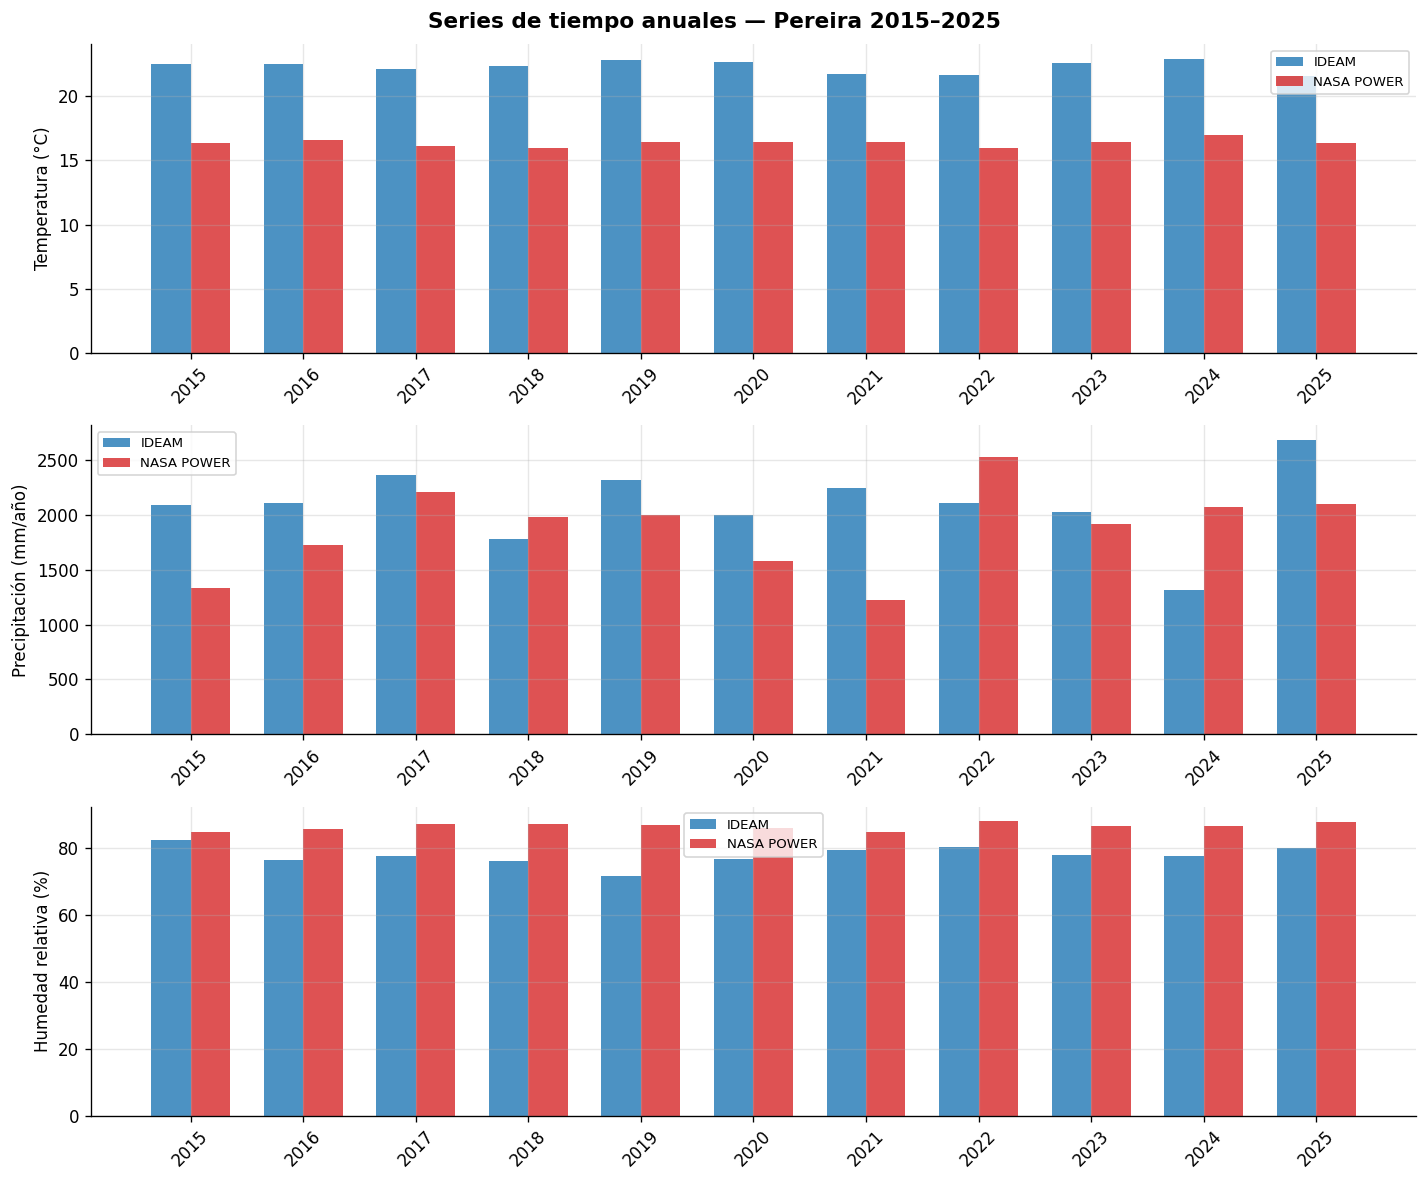

In [5]:
# ============================================================
# 5C. SERIES ANUALES
# ============================================================
ideam_a = ideam.resample('YE').mean(numeric_only=True)
nasa_a  = nasa.resample('YE').mean(numeric_only=True)

# Precipitación anual = suma
ideam_a['precipitacion_mm'] = ideam.resample('YE')['precipitacion_mm'].sum(min_count=1)
nasa_a['precipitacion_mm']  = nasa.resample('YE')['precipitacion_mm'].sum(min_count=1)

years = ideam_a.index.year
x = np.arange(len(years))
width = 0.35

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Series de tiempo anuales — Pereira 2015–2025', fontsize=13, fontweight='bold')

for ax, (col, (nombre, unidad)) in zip(axes, VARS.items()):
    unidad_a = 'mm/año' if col == 'precipitacion_mm' else unidad
    ax.bar(x - width/2, ideam_a[col], width, color=C_IDEAM, alpha=0.8, label='IDEAM')
    ax.bar(x + width/2, nasa_a[col],  width, color=C_NASA,  alpha=0.8, label='NASA POWER')
    ax.set_ylabel(f'{nombre} ({unidad_a})')
    ax.set_xticks(x)
    ax.set_xticklabels(years, rotation=45)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('../results/plots/03_series_anuales.png', bbox_inches='tight')
plt.show()

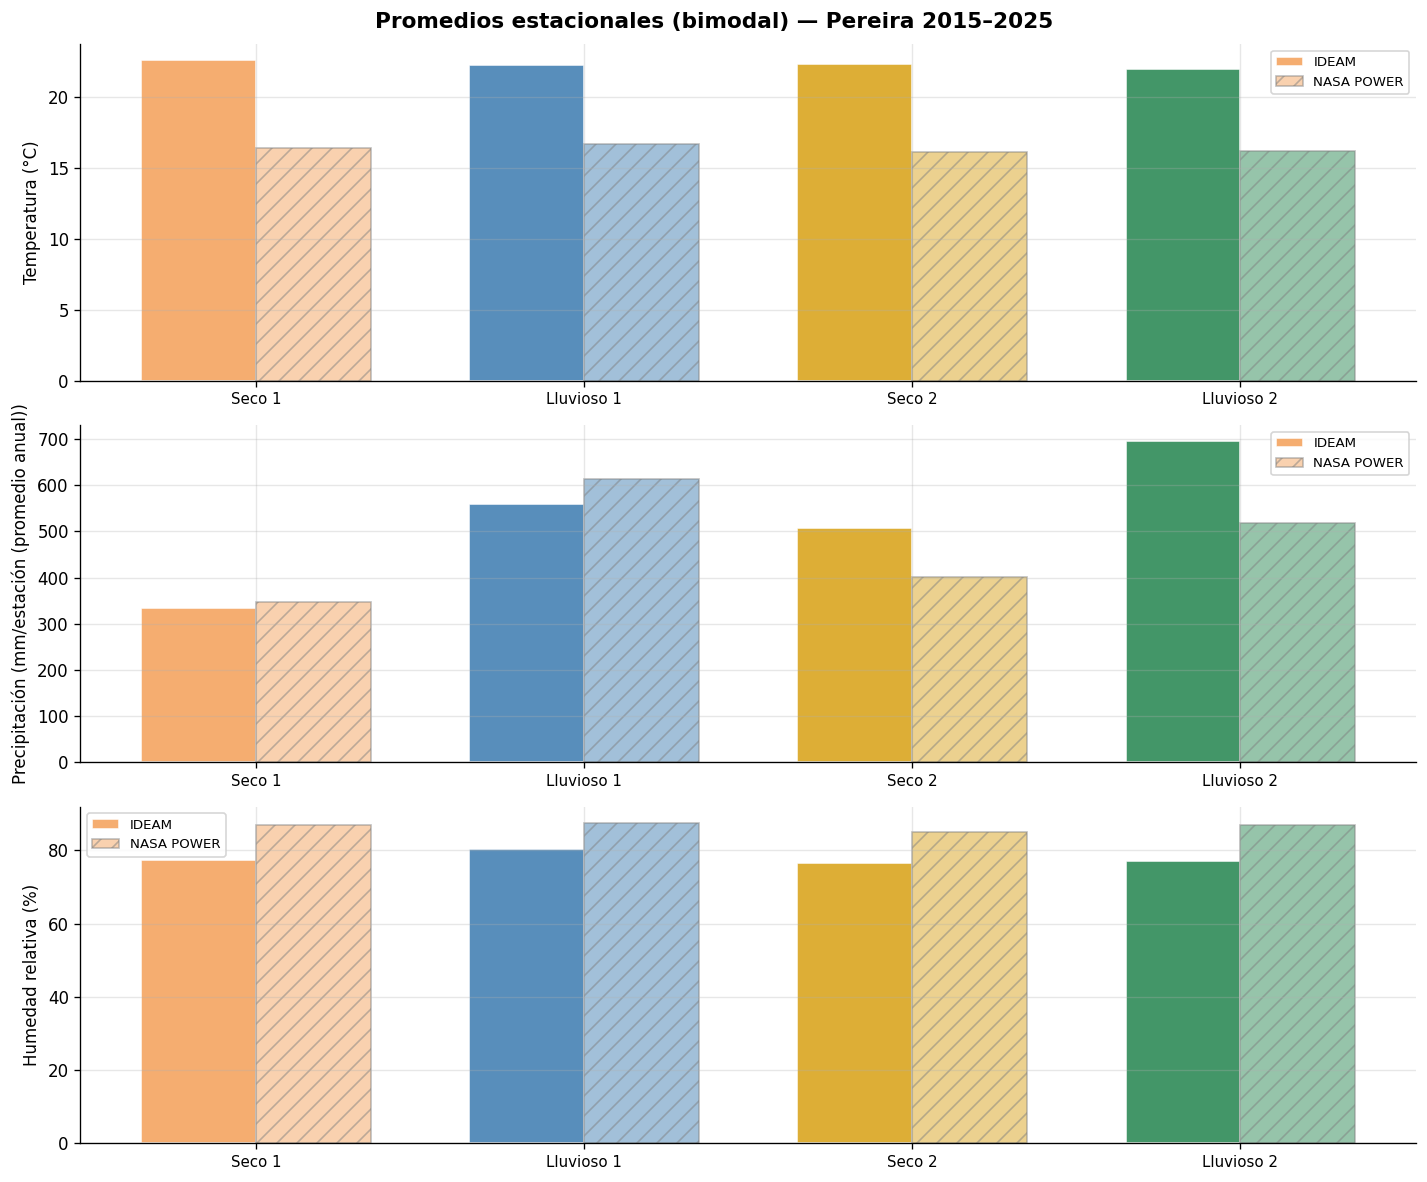

In [6]:
# ============================================================
# 5D. SERIES ESTACIONALES (BIMODAL EJE CAFETERO)
# ============================================================
def asignar_estacion(mes):
    for nombre, meses in ESTACIONES.items():
        if mes in meses:
            return nombre
    return None

ideam_e = ideam.copy()
nasa_e  = nasa.copy()
ideam_e['estacion'] = ideam_e.index.month.map(asignar_estacion)
nasa_e['estacion']  = nasa_e.index.month.map(asignar_estacion)

orden  = list(ESTACIONES.keys())
x      = np.arange(len(orden))
width  = 0.35
n_años = ideam_e.index.year.nunique()

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Promedios estacionales (bimodal) — Pereira 2015–2025', fontsize=13, fontweight='bold')

for ax, (col, (nombre, unidad)) in zip(axes, VARS.items()):
    if col == 'precipitacion_mm':
        vals_i = [ideam_e[ideam_e['estacion'] == e][col].sum() / n_años for e in orden]
        vals_n = [nasa_e[nasa_e['estacion'] == e][col].sum()  / n_años for e in orden]
        unidad_e = 'mm/estación (promedio anual)'
    else:
        vals_i = [ideam_e[ideam_e['estacion'] == e][col].mean() for e in orden]
        vals_n = [nasa_e[nasa_e['estacion'] == e][col].mean()   for e in orden]
        unidad_e = unidad

    colors = [ESTACION_COLORS[e] for e in orden]
    ax.bar(x - width/2, vals_i, width, color=colors, alpha=0.9, label='IDEAM', edgecolor='white')
    ax.bar(x + width/2, vals_n, width, color=colors, alpha=0.5, label='NASA POWER', edgecolor='gray', hatch='//')
    ax.set_ylabel(f'{nombre} ({unidad_e})')
    ax.set_xticks(x)
    ax.set_xticklabels([e.split('(')[0].strip() for e in orden], fontsize=9)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('../results/plots/04_series_estacionales.png', bbox_inches='tight')
plt.show()

In [7]:
# ============================================================
# 5E. ANOMALÍAS
# La anomalía se calcula como: valor - media climatológica del período
# Se calcula en escala diaria, mensual, anual y estacional
# ============================================================

# --- Media climatológica por día del año (daily climatology) ---
ideam['doy'] = ideam.index.day_of_year
nasa['doy']  = nasa.index.day_of_year

clim_ideam = ideam.groupby('doy')[list(VARS.keys())].mean()
clim_nasa  = nasa.groupby('doy')[list(VARS.keys())].mean()

# Anomalías diarias
anom_ideam_d = ideam[list(VARS.keys())].copy()
anom_nasa_d  = nasa[list(VARS.keys())].copy()

for col in VARS:
    anom_ideam_d[col] = ideam[col] - ideam['doy'].map(clim_ideam[col])
    anom_nasa_d[col]  = nasa[col]  - nasa['doy'].map(clim_nasa[col])

# Anomalías mensuales
# Temperatura y humedad: climatología = promedio mensual
# Precipitación: climatología = suma mensual promedio entre años
clim_ideam_m = ideam.groupby(ideam.index.month)[list(VARS.keys())].mean()
clim_nasa_m  = nasa.groupby(nasa.index.month)[list(VARS.keys())].mean()
clim_ideam_m['precipitacion_mm'] = ideam.groupby(ideam.index.month)['precipitacion_mm'].sum() / ideam.index.year.nunique()
clim_nasa_m['precipitacion_mm']  = nasa.groupby(nasa.index.month)['precipitacion_mm'].sum()   / nasa.index.year.nunique()

ideam_m_vals = ideam.resample('ME').mean(numeric_only=True)
ideam_m_vals['precipitacion_mm'] = ideam.resample('ME')['precipitacion_mm'].sum(min_count=1)
nasa_m_vals  = nasa.resample('ME').mean(numeric_only=True)
nasa_m_vals['precipitacion_mm']  = nasa.resample('ME')['precipitacion_mm'].sum(min_count=1)

anom_ideam_m = ideam_m_vals.copy()
anom_nasa_m  = nasa_m_vals.copy()
for col in VARS:
    anom_ideam_m[col] = ideam_m_vals[col] - clim_ideam_m[col].reindex(ideam_m_vals.index.month).values
    anom_nasa_m[col]  = nasa_m_vals[col]  - clim_nasa_m[col].reindex(nasa_m_vals.index.month).values

# Anomalías anuales
clim_ideam_a = ideam[list(VARS.keys())].mean()
clim_nasa_a  = nasa[list(VARS.keys())].mean()
clim_ideam_a['precipitacion_mm'] = ideam['precipitacion_mm'].sum() / ideam.index.year.nunique()
clim_nasa_a['precipitacion_mm']  = nasa['precipitacion_mm'].sum()  / nasa.index.year.nunique()

anom_ideam_a = ideam_a - clim_ideam_a
anom_nasa_a  = nasa_a  - clim_nasa_a

print('Anomalías calculadas correctamente.')

Anomalías calculadas correctamente.


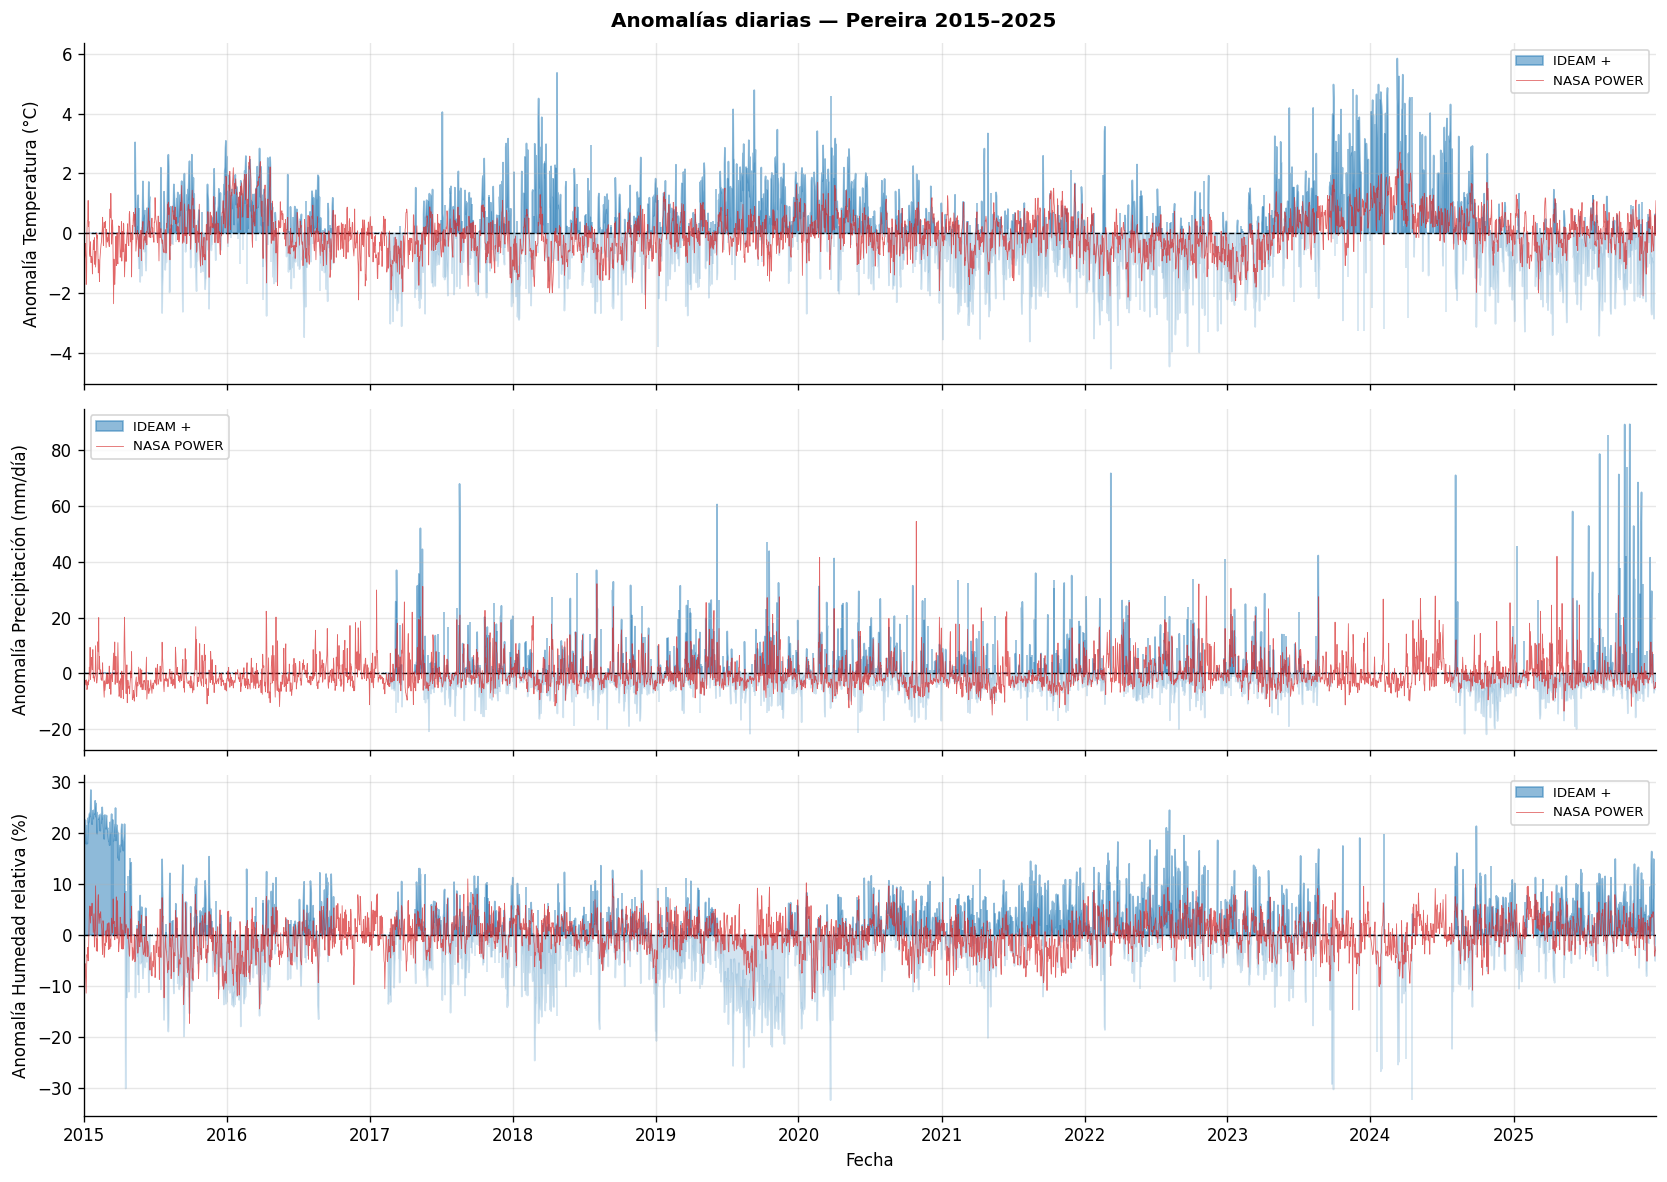

In [8]:
# --- Anomalías diarias ---
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle('Anomalías diarias — Pereira 2015–2025', fontsize=12, fontweight='bold')

for ax, (col, (nombre, unidad)) in zip(axes, VARS.items()):
    ax.axhline(0, color='black', lw=0.8, ls='--')
    ax.fill_between(anom_ideam_d.index, anom_ideam_d[col], 0,
                    where=anom_ideam_d[col] >= 0, color=C_IDEAM, alpha=0.5, label='IDEAM +')
    ax.fill_between(anom_ideam_d.index, anom_ideam_d[col], 0,
                    where=anom_ideam_d[col] <  0, color=C_IDEAM, alpha=0.2)
    ax.plot(anom_nasa_d.index, anom_nasa_d[col], color=C_NASA, lw=0.5, alpha=0.7, label='NASA POWER')
    ax.set_ylabel(f'Anomalía {nombre} ({unidad})')
    ax.legend(fontsize=8)

axes[-1].set_xlim(FECHA_INI, FECHA_FIN)
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.savefig('../results/plots/05_anomalias_diarias.png', bbox_inches='tight')
plt.show()

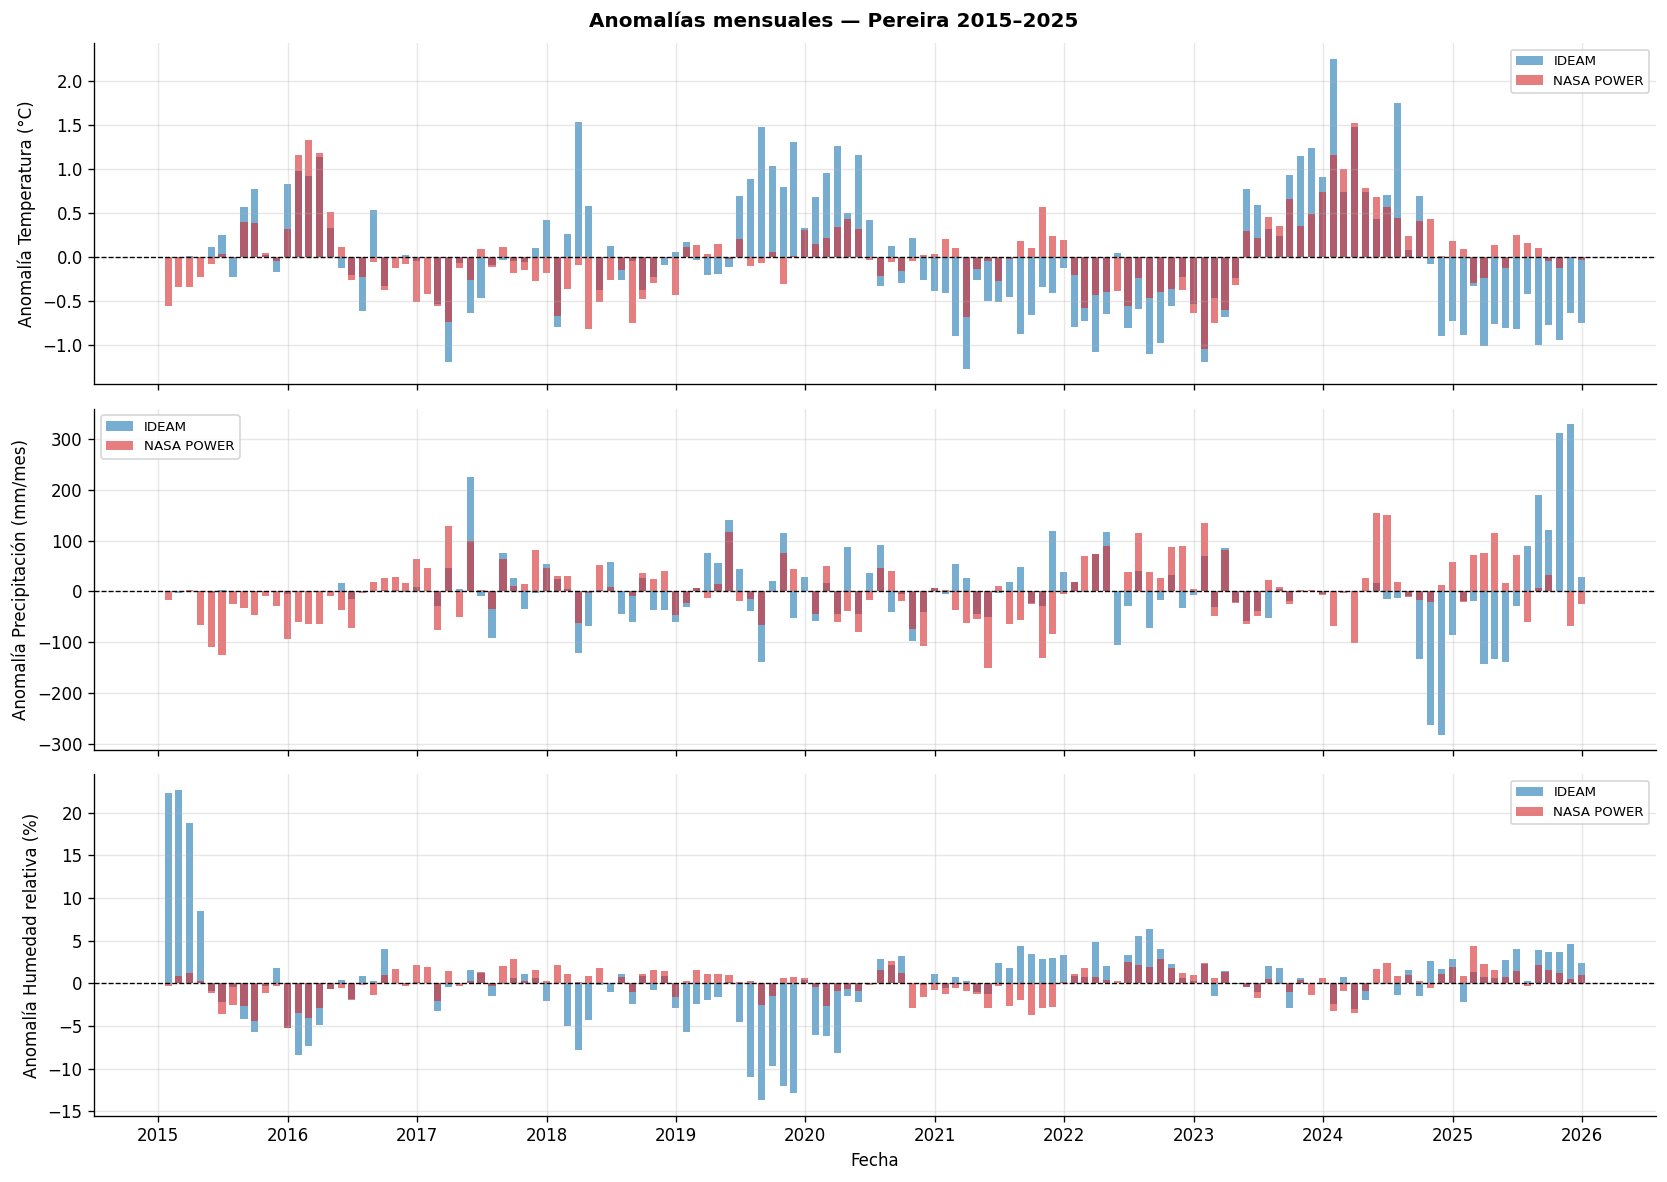

In [9]:
# --- Gráficos de anomalías mensuales ---
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle('Anomalías mensuales — Pereira 2015–2025', fontsize=12, fontweight='bold')

for ax, (col, (nombre, unidad)) in zip(axes, VARS.items()):
    unidad_m = 'mm/mes' if col == 'precipitacion_mm' else unidad
    ax.axhline(0, color='black', lw=0.8, ls='--')
    for df_anom, color, label in [(anom_ideam_m, C_IDEAM, 'IDEAM'), (anom_nasa_m, C_NASA, 'NASA POWER')]:
        ax.bar(df_anom.index, df_anom[col], width=20,
               color=[color if v >= 0 else color for v in df_anom[col]],
               alpha=0.6, label=label)
    ax.set_ylabel(f'Anomalía {nombre} ({unidad_m})')
    ax.legend(fontsize=8)

axes[-1].xaxis.set_major_locator(mdates.YearLocator())
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.savefig('../results/plots/06_anomalias_mensuales.png', bbox_inches='tight')
plt.show()

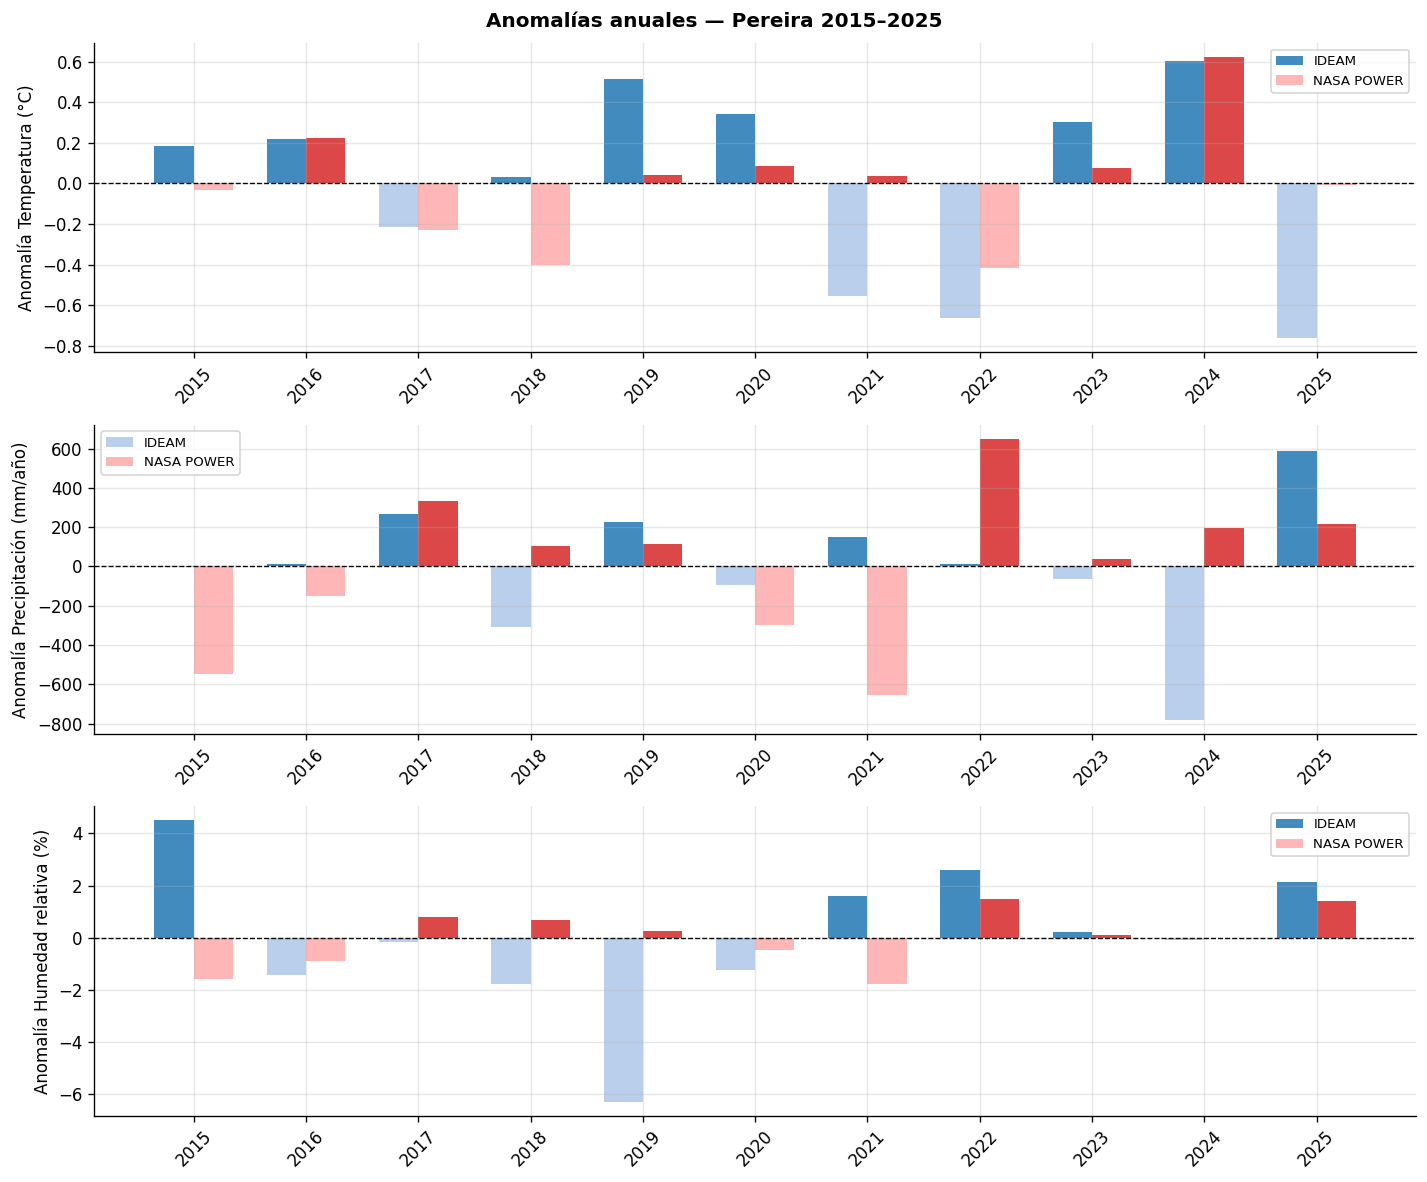

In [10]:
# --- Anomalías anuales ---
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
fig.suptitle('Anomalías anuales — Pereira 2015–2025', fontsize=12, fontweight='bold')

x = np.arange(len(anom_ideam_a))
width = 0.35

for ax, (col, (nombre, unidad)) in zip(axes, VARS.items()):
    unidad_a = 'mm/año' if col == 'precipitacion_mm' else unidad
    vals_i = anom_ideam_a[col].values
    vals_n = anom_nasa_a[col].values
    colors_i = [C_IDEAM if v >= 0 else '#aec7e8' for v in vals_i]
    colors_n = [C_NASA  if v >= 0 else '#ffaaaa' for v in vals_n]
    ax.bar(x - width/2, vals_i, width, color=colors_i, alpha=0.85, label='IDEAM')
    ax.bar(x + width/2, vals_n, width, color=colors_n, alpha=0.85, label='NASA POWER')
    ax.axhline(0, color='black', lw=0.8, ls='--')
    ax.set_ylabel(f'Anomalía {nombre} ({unidad_a})')
    ax.set_xticks(x)
    ax.set_xticklabels(anom_ideam_a.index.year, rotation=45)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('../results/plots/07_anomalias_anuales.png', bbox_inches='tight')
plt.show()

---
## Punto 6 — Histogramas y distribuciones

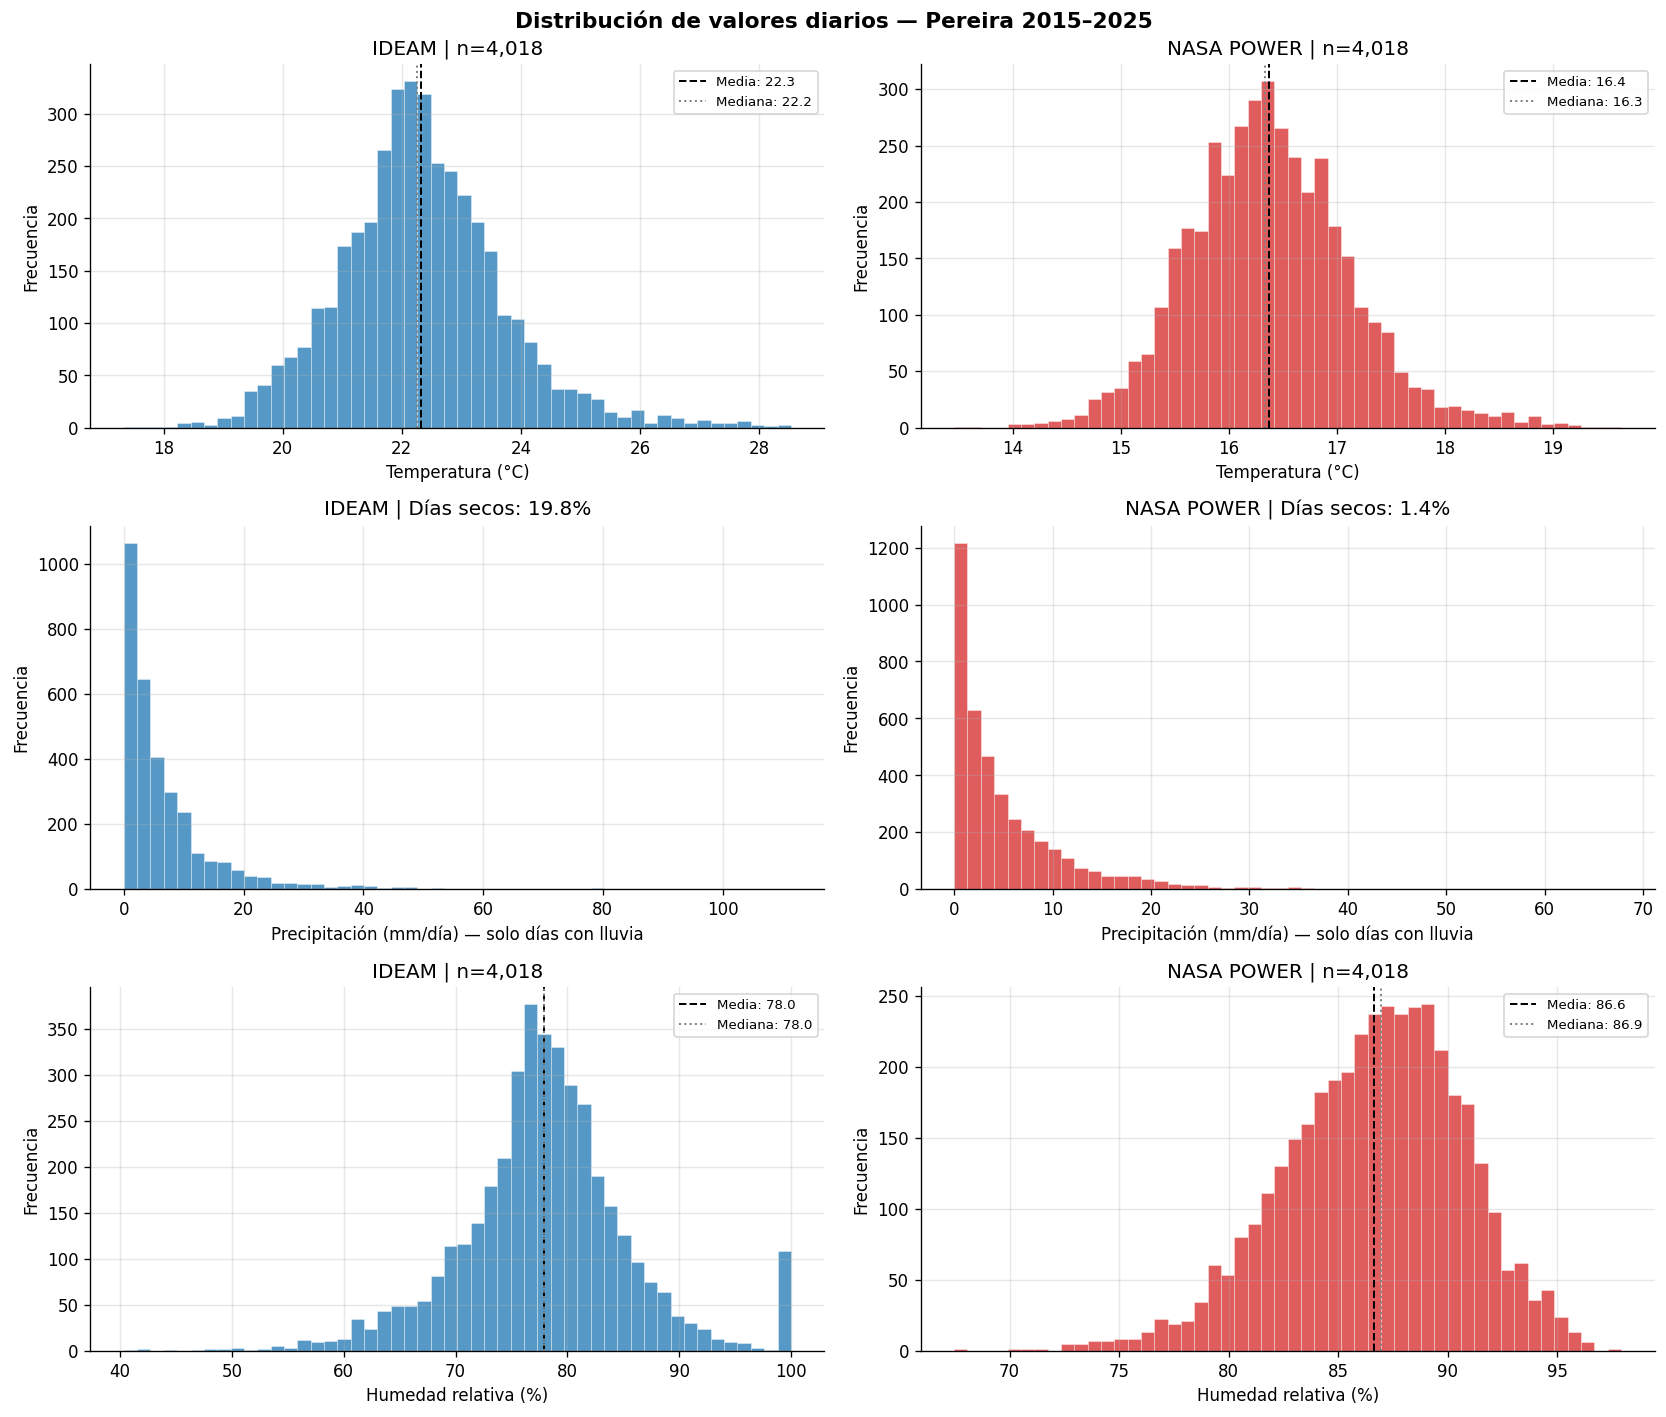

In [11]:
# ============================================================
# 6. HISTOGRAMAS DIARIOS POR VARIABLE Y FUENTE
# ============================================================
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Distribución de valores diarios — Pereira 2015–2025', fontsize=13, fontweight='bold')

for row, (col, (nombre, unidad)) in enumerate(VARS.items()):
    for ax, (df, fuente, color) in zip(axes[row], [
        (ideam, 'IDEAM',      C_IDEAM),
        (nasa,  'NASA POWER', C_NASA),
    ]):
        datos = df[col].dropna()

        if col == 'precipitacion_mm':
            lluviosos = datos[datos > 0]
            pct_seco  = 100 * (datos == 0).sum() / len(datos)
            ax.hist(lluviosos, bins=50, color=color, alpha=0.75, edgecolor='white', lw=0.3)
            ax.set_xlabel(f'{nombre} ({unidad}) — solo días con lluvia')
            ax.set_title(f'{fuente} | Días secos: {pct_seco:.1f}%')
        else:
            ax.hist(datos, bins=50, color=color, alpha=0.75, edgecolor='white', lw=0.3)
            ax.axvline(datos.mean(),   color='black', ls='--', lw=1.2, label=f'Media: {datos.mean():.1f}')
            ax.axvline(datos.median(), color='gray',  ls=':',  lw=1.2, label=f'Mediana: {datos.median():.1f}')
            ax.set_xlabel(f'{nombre} ({unidad})')
            ax.set_title(f'{fuente} | n={len(datos):,}')
            ax.legend(fontsize=8)

        ax.set_ylabel('Frecuencia')

plt.tight_layout()
plt.savefig('../results/plots/08_histogramas.png', bbox_inches='tight')
plt.show()

---
## Punto 7 — Análisis de Fourier

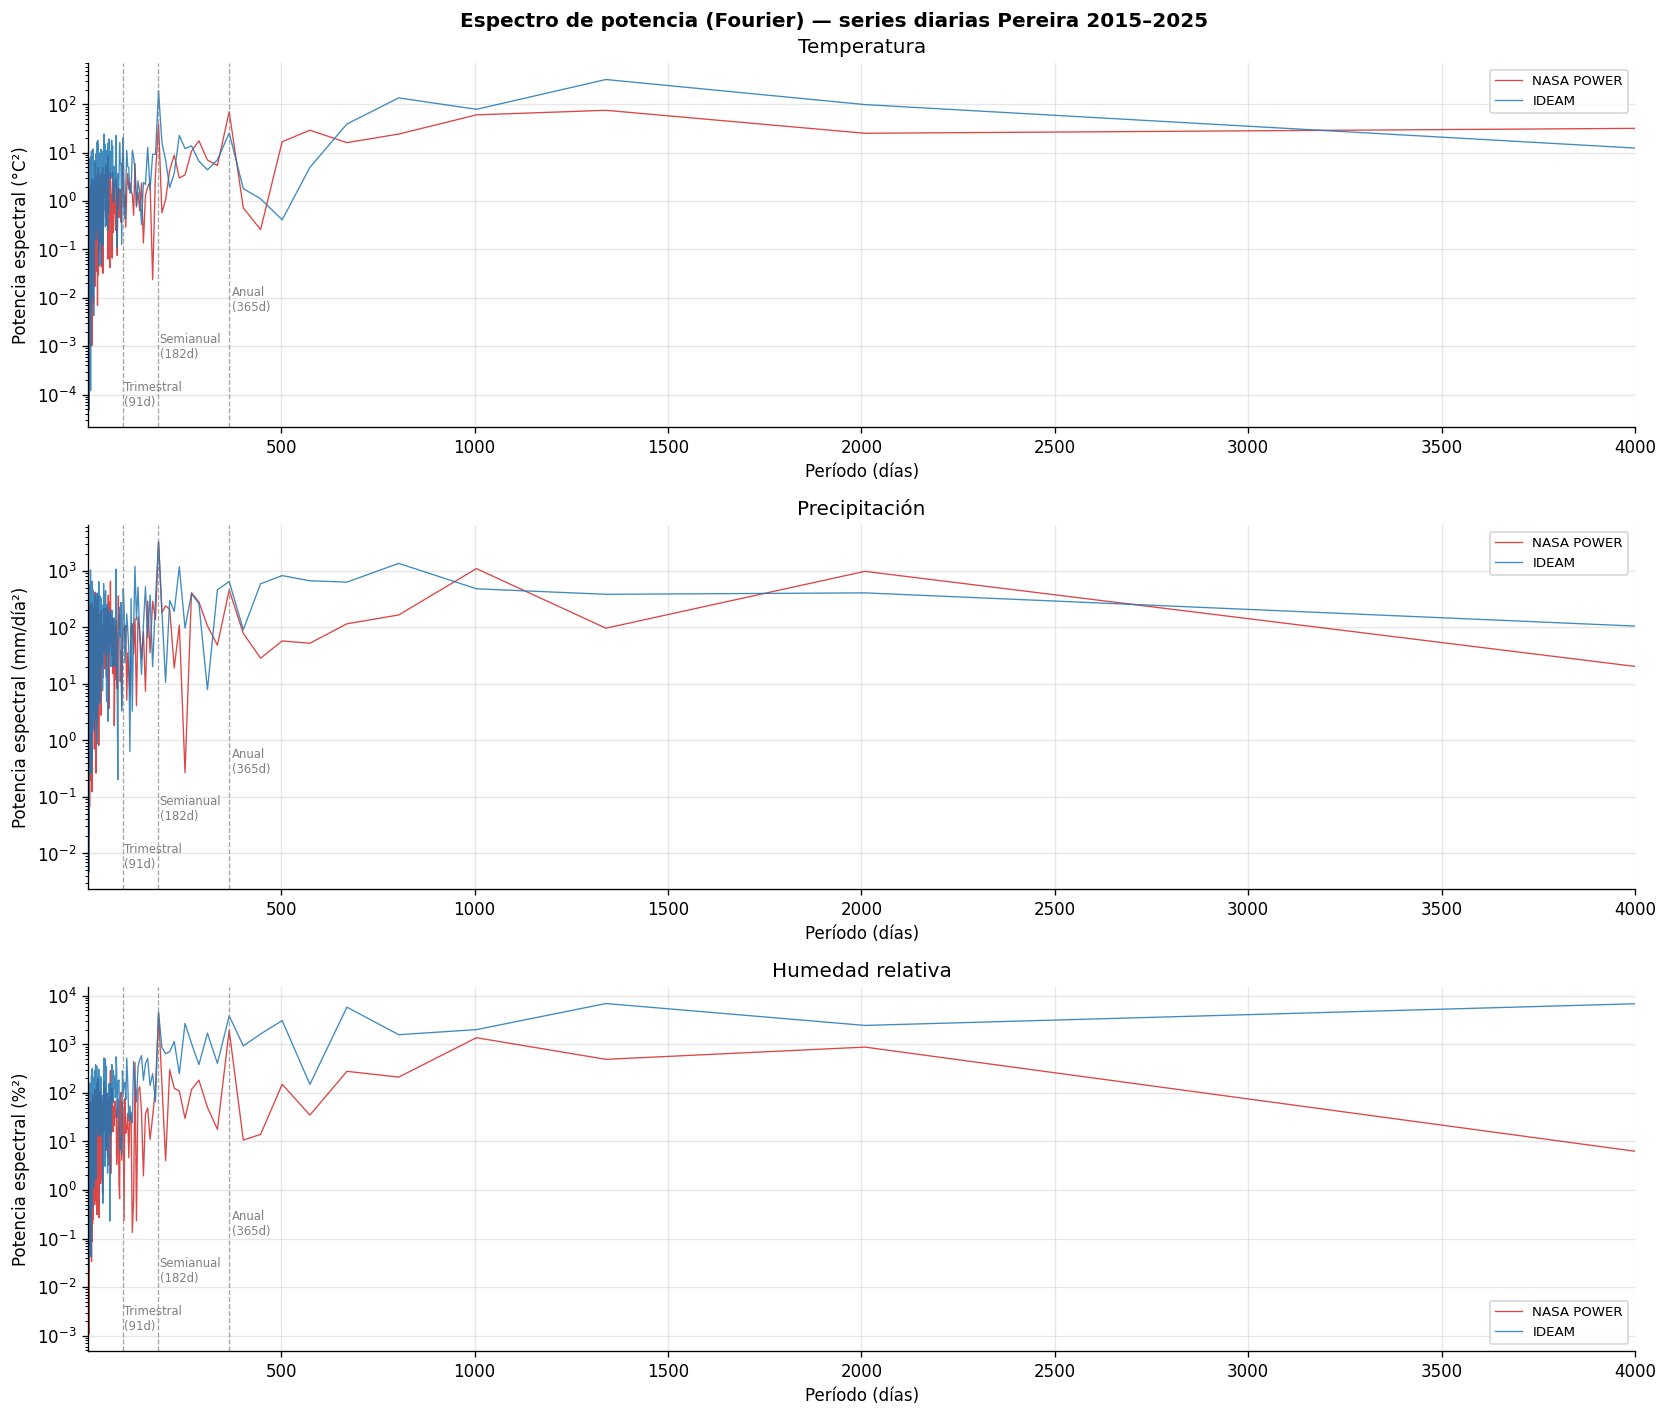

In [15]:
# ============================================================
# 7. FOURIER ANALYSIS
# NASA POWER is used as a continuous series (no NULLs).
# IDEAM is linearly interpolated before applying FFT.
# ============================================================

def calcular_espectro(serie):
    """Compute power spectrum of a daily time series.
    Returns frequencies (cycles/day) and power."""

    # Interpolación segura (forma moderna)
    s = (
        serie
        .interpolate(method='linear')
        .bfill()
        .ffill()
    )

    # Remover media (detrending básico)
    s = s - s.mean()

    N = len(s)

    # FFT
    Y = np.fft.fft(s.values)
    freqs = np.fft.fftfreq(N, d=1)  # d=1 día

    potencia = (np.abs(Y) ** 2) / N

    # Solo frecuencias positivas
    mask = freqs > 0
    return freqs[mask], potencia[mask]


# Altura escalonada para evitar solapamiento de etiquetas
periodos_ref = {
    'Trimestral\n(91d)':  (91,  0.05),
    'Semianual\n(182d)': (182, 0.18),
    'Anual\n(365d)':     (365, 0.31),
}

fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('Espectro de potencia (Fourier) — series diarias Pereira 2015–2025',
             fontsize=12, fontweight='bold')

for ax, (col, (nombre, unidad)) in zip(axes, VARS.items()):
    for df, fuente, color in [(nasa, 'NASA POWER', C_NASA), (ideam, 'IDEAM', C_IDEAM)]:
        freqs, potencia = calcular_espectro(df[col])
        periodos = 1 / freqs
        ax.semilogy(periodos, potencia, color=color, lw=0.8, alpha=0.85, label=fuente)

    for label, (periodo, y_frac) in periodos_ref.items():
        ax.axvline(periodo, color='gray', ls='--', lw=0.8, alpha=0.7)
        ax.text(periodo * 1.02, y_frac, label,
                transform=ax.get_xaxis_transform(),
                fontsize=7, ha='left', va='bottom', color='gray')

    ax.set_xlabel('Período (días)')
    ax.set_ylabel(f'Potencia espectral ({unidad}²)')
    ax.set_title(f'{nombre}')
    ax.set_xlim(1, 4000)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('../results/plots/09_fourier.png', bbox_inches='tight')
plt.show()

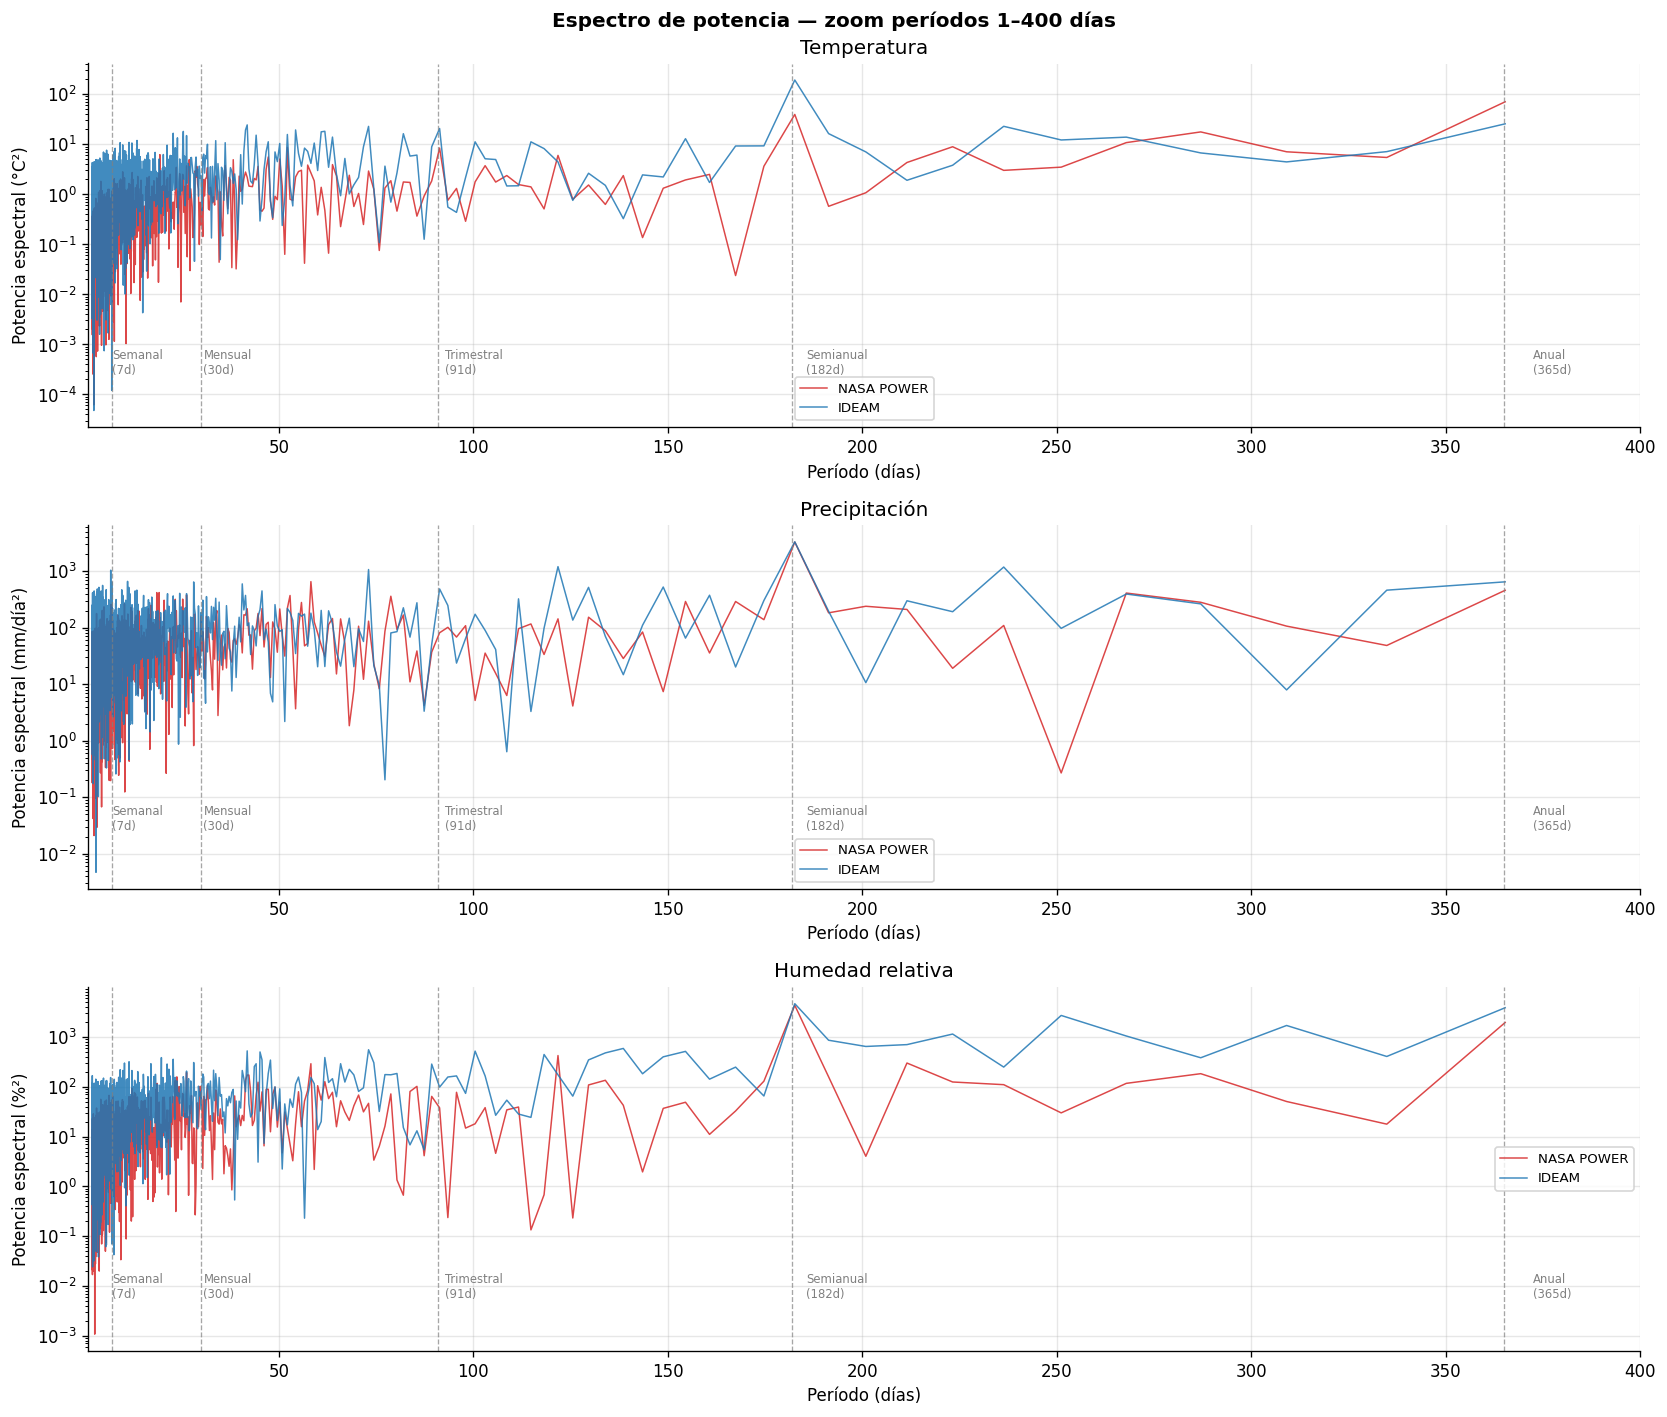

In [13]:
# --- Zoom en períodos subanuales (1–400 días) ---
periodos_ref_zoom = {
    'Anual\n(365d)':     365,
    'Semianual\n(182d)': 182,
    'Trimestral\n(91d)':  91,
    'Mensual\n(30d)':      30,
    'Semanal\n(7d)':        7,
}

fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('Espectro de potencia — zoom períodos 1–400 días',
             fontsize=12, fontweight='bold')

for ax, (col, (nombre, unidad)) in zip(axes, VARS.items()):
    for df, fuente, color in [(nasa, 'NASA POWER', C_NASA), (ideam, 'IDEAM', C_IDEAM)]:
        freqs, potencia = calcular_espectro(df[col])
        periodos = 1 / freqs
        mask = (periodos >= 1) & (periodos <= 400)
        ax.semilogy(periodos[mask], potencia[mask], color=color, lw=0.9, alpha=0.85, label=fuente)

    for label, periodo in periodos_ref_zoom.items():
        ax.axvline(periodo, color='gray', ls='--', lw=0.8, alpha=0.7)
        ax.text(periodo * 1.02, ax.get_ylim()[0] * 10,
                label, fontsize=7, ha='left', va='bottom', color='gray')

    ax.set_xlabel('Período (días)')
    ax.set_ylabel(f'Potencia espectral ({unidad}²)')
    ax.set_title(f'{nombre}')
    ax.set_xlim(1, 400)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('../results/plots/10_fourier_zoom.png', bbox_inches='tight')
plt.show()